In [1]:
#input data Image 데이터로 Batch 만들어 넣기
#https://medium.com/trackin-datalabs/data-input-%EB%A7%8C%EB%93%A4%EA%B8%B0-74bb5c1ce52f

# 필요한 패키지들 
import os 
from glob import glob
# PIL는 이미지를 load 할 때, numpy는 array 
from PIL import Image
import numpy as np

import cv2
import matplotlib.pyplot as plt

In [2]:
#폴더로 데이터 리스트 추출
data_list = glob('D:/pythonWorkspace/COVID_DATA/collection-re2/fuzzyColor/*/*.jpg')  # 모든 경로들을 list로 반환
# 여기서 path를 하나 뽑고서 이것으로 이미지를 불러오고, Label도 불러올 것이다. 
path = data_list[0]  
print(path)

D:/pythonWorkspace/COVID_DATA/collection-re2/fuzzyColor\COVID19\0001.jpg


In [3]:
#경로 폴더 이름을 통한 라벨링
def get_label_from_path(path):
    return (path.split('\\')[-2])

In [4]:
#라벨링 제대로 되는지 확인작업
rand_n = 267  # <- 아무 숫자나 넣은 거다 
path = data_list[rand_n]
path, get_label_from_path(path)  # 제대로 뽑아졌는지 확인

('D:/pythonWorkspace/COVID_DATA/collection-re2/fuzzyColor\\COVID19\\0268.jpg',
 'COVID19')

In [5]:
# path로 부터 Image 불러오기
image = np.array(Image.open(path))

def read_image(path):
    image = np.array(Image.open(path))
    
    #추가 코드 cv2 이용
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    #plt.imshow(img)
    #plt.show()
    img = cv2.resize(255-img,(224, 224))

    test = img.flatten() / 255.0
    test = img.reshape((224, 224, 1))
    
    ##
    
    #print(image.shape[0]) # 가로 크기 :224px
    #print(image.shape[1]) # 세로 크기 :224px
    # Channel 1을 살려주기 위해 reshape 해줌
    # returnimage.reshape(image.shape[0], image.shape[1], 1) #에러나서 변경
    return test

# label 이름을 통해 onehot-encoding 하기 
class_name = get_label_from_path(path)

# 앞서 만들었던 get_label_from_path 함수를 통해 data_list에 있는 label 이름들을 list에 다 묶어준다
# 더 쉬운 방법이 있지만, 굳이 함수를 통해 label 들을 얻는 것은 함수도 잘 작동하는지 확인함을 목적을 가지고 있다. 
label_name_list = []

for path in data_list:
    label_name_list.append(get_label_from_path(path))
    
unique_label_names = np.unique(label_name_list)

# one-hot Encoding
def onehot_encode_label(path):
    onehot_label = unique_label_names == get_label_from_path(path) #중복을 제거한 라벨리스트와 동일한 것만 1, 나머지 0 
    onehot_label = onehot_label.astype(np.uint8) #
    return onehot_label

print(path)
print(onehot_encode_label(path))  # 어떤 식으로 나오는지 꼭 확인해보자!!
print(unique_label_names)  # 중복을 제거한 라벨 리스트['COVID19' 'NORMAL' 'Viral Pneumonia']


D:/pythonWorkspace/COVID_DATA/collection-re2/fuzzyColor\Viral Pneumonia\1345.jpg
[0 0 1]
['COVID19' 'NORMAL' 'Viral Pneumonia']


batch_image.shape :  (64, 224, 224, 1)
batch_label.shape :  (64, 3)
batch label :  [1. 0. 0.]


C:\Anaconda3\envs\tensorflow3.6.5\lib\site-packages\matplotlib\text.py:1163: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


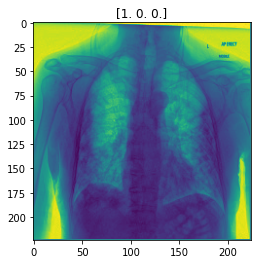

In [6]:
#Batch 파일로 만들기

# Hyper Parameter 
batch_size = 64
data_height = 224
data_width = 224
channel_n = 1
num_classes = 3

# 방법.1 - Empty Array를 만들고 채워가는 방법
batch_image = np.zeros((batch_size, data_height, data_width, channel_n))
batch_label = np.zeros((batch_size, num_classes))

# 간단한 batch data 만들기
for n, path in enumerate(data_list[:batch_size]):
    image = read_image(path)
    onehot_label = onehot_encode_label(path)
    batch_image[n, :, :, :] = image
    batch_label[n, :] = onehot_label

print("batch_image.shape : " ,batch_image.shape)
print("batch_label.shape : " ,batch_label.shape)


test_n = 0
print("batch label : ",batch_label[test_n])
plt.title(batch_label[test_n])
plt.imshow(batch_image[test_n, :, :, 0])
plt.show()

In [7]:
# Batch 데이터 생성
batch_per_epoch = batch_size // len(data_list)
# for batch_n in range(batch_per_epoch):
#     batch_data = data_list[batch_n * batch_size : (batch_n + 1) * batch_size]

In [8]:
#https://www.tensorflow.org/guide/data
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

def _read_py_function(path, label):
    path =path.decode('utf-8')
    path =path.replace("\\","/",10);
    #print(path)
    image = read_image(path)
    label = np.array(label, dtype=np.uint8)
    return image.astype(np.int32), label
def _resize_function(image_decoded, label):
    image_decoded.set_shape([None, None, None])
    image_resized = tf.image.resize_images(image_decoded, [28, 28])
    return image_resized, label
# label을 array 통채로 넣는게 아니고, list 화 시켜서 하나씩 넣기 위해 list로 바꿔주었다. 
label_list = [onehot_encode_label(path).tolist() for path in data_list]
dataset = tf.data.Dataset.from_tensor_slices((data_list, label_list))
dataset = dataset.map(
    lambda data_list, label_list: tuple(tf.py_func(_read_py_function, [data_list, label_list], [tf.int32, tf.uint8])))
dataset = dataset.map(_resize_function)
dataset = dataset.repeat()
dataset = dataset.shuffle(buffer_size=(int(len(data_list) * 0.4) + 3 * batch_size))
dataset = dataset.batch(batch_size)
iterator = dataset.make_initializable_iterator()
image_stacked, label_stacked = iterator.get_next()
next_element = iterator.get_next()

with tf.Session() as sess:
    sess.run(iterator.initializer)
    image, label = sess.run([image_stacked, label_stacked])



"""
@tf.function
def running(dataset) :
    for next_element in dataset :
        print(next_element)
        #image. label = next_element.

running(dataset)
"""


Instructions for updating:
non-resource variables are not supported in the long term
Instructions for updating:
tf.py_func is deprecated in TF V2. Instead, there are two
    options available in V2.
    - tf.py_function takes a python function which manipulates tf eager
    tensors instead of numpy arrays. It's easy to convert a tf eager tensor to
    an ndarray (just call tensor.numpy()) but having access to eager tensors
    means `tf.py_function`s can use accelerators such as GPUs as well as
    being differentiable using a gradient tape.
    - tf.numpy_function maintains the semantics of the deprecated tf.py_func
    (it is not differentiable, and manipulates numpy arrays). It drops the
    stateful argument making all functions stateful.
    
Instructions for updating:
This is a deprecated API that should only be used in TF 1 graph mode and legacy TF 2 graph mode available through `tf.compat.v1`. In all other situations -- namely, eager mode and inside `tf.function` -- you can con

'\n@tf.function\ndef running(dataset) :\n    for next_element in dataset :\n        print(next_element)\n        #image. label = next_element.\n\nrunning(dataset)\n'

In [9]:
print(dataset)

<DatasetV1Adapter shapes: ((?, 28, 28, ?), <unknown>), types: (tf.float32, tf.uint8)>
